In [1]:
import sys
sys.path.append('../')
import src.utils as utils
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
reload(utils)
import scipy.stats as stat

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"
import warnings
warnings.filterwarnings("ignore")

import matplotlib
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsfonts}')

In [3]:
params = {
    'r' : 0.01,
    'p' : 0.5 ,
    'u' : 1.02,
    'd' : 0.99,
    'T' : 1,
    'S0' : 100,
    'Nt': 10,
}

BT = utils.binomial_tree(**params)

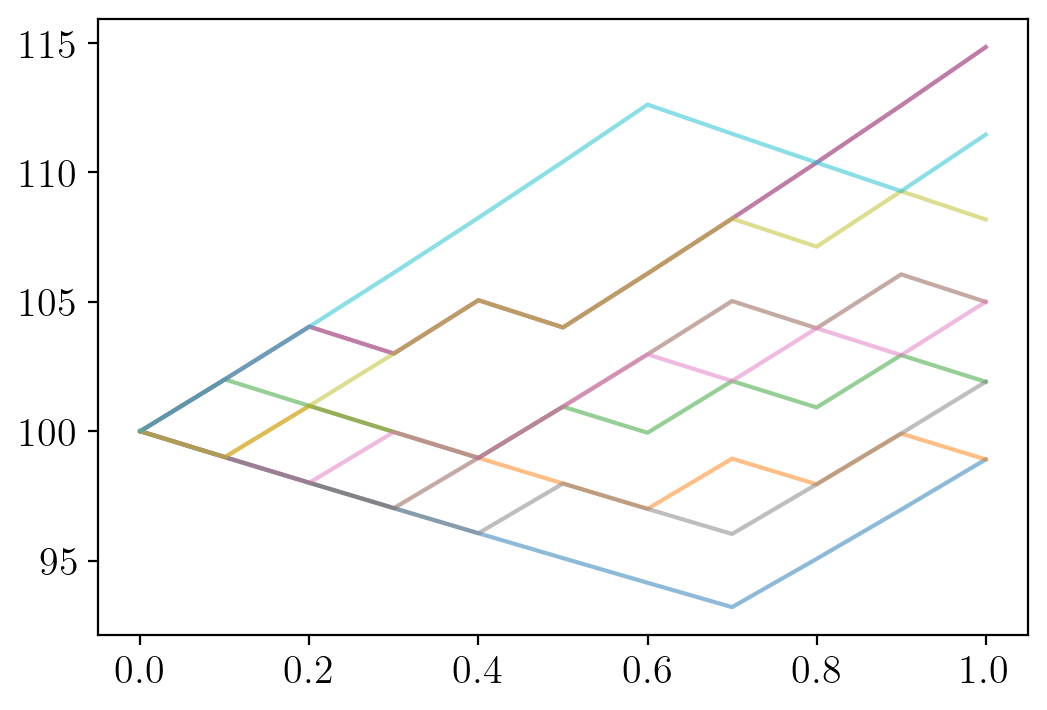

In [4]:
plt.plot(BT.timesteps, BT.simulate(nsims = 10), alpha = 0.5)
plt.show()

In [5]:
sigma = 0.2
Nt = 1000
T = 1.
mu = 0.03
r = 0.01
u = 1. + sigma * np.sqrt(T/Nt)
d = 1./u
p = 0.5 + (mu / (2.*sigma) - sigma/4)* np.sqrt(T/Nt)

params = {
    'r' : r,
    'p' : p,
    'u' : u,
    'd' : d,
    'T' : T,
    'S0' : 100,
    'Nt': Nt,
}

BT = utils.binomial_tree(**params)

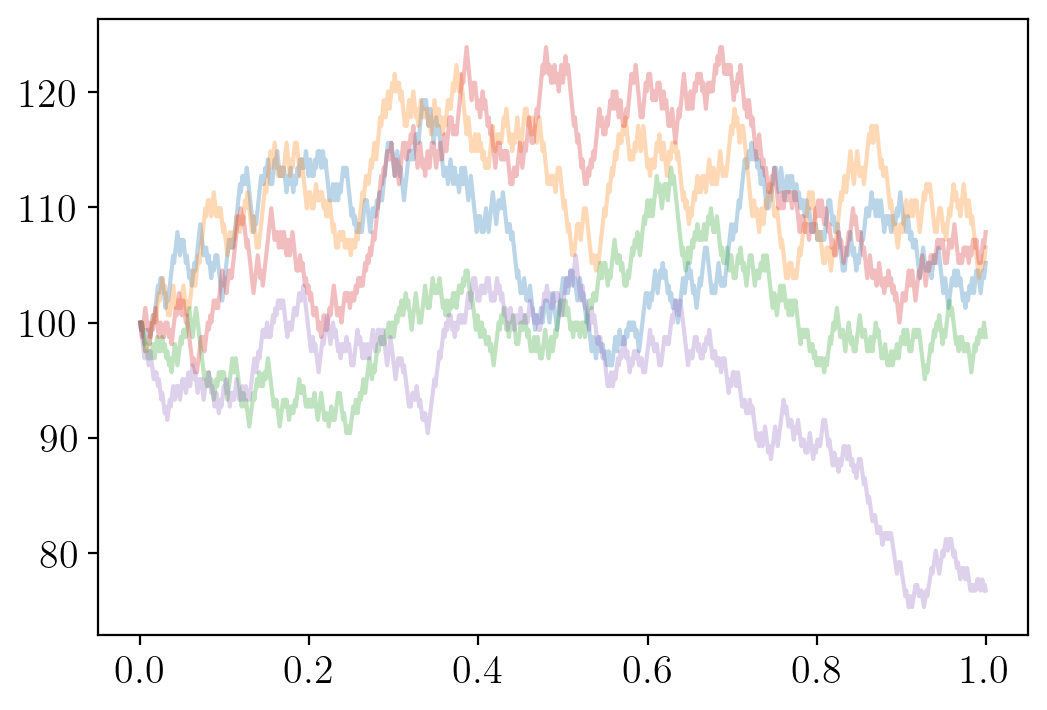

In [6]:
plt.plot(BT.timesteps, BT.simulate(nsims = 5), alpha = 0.3)
plt.show()

In [7]:
GBM = utils.GeometricBrownianMotion(x0 = 100., mu = mu, sigma = sigma, T = T, Nt = Nt)

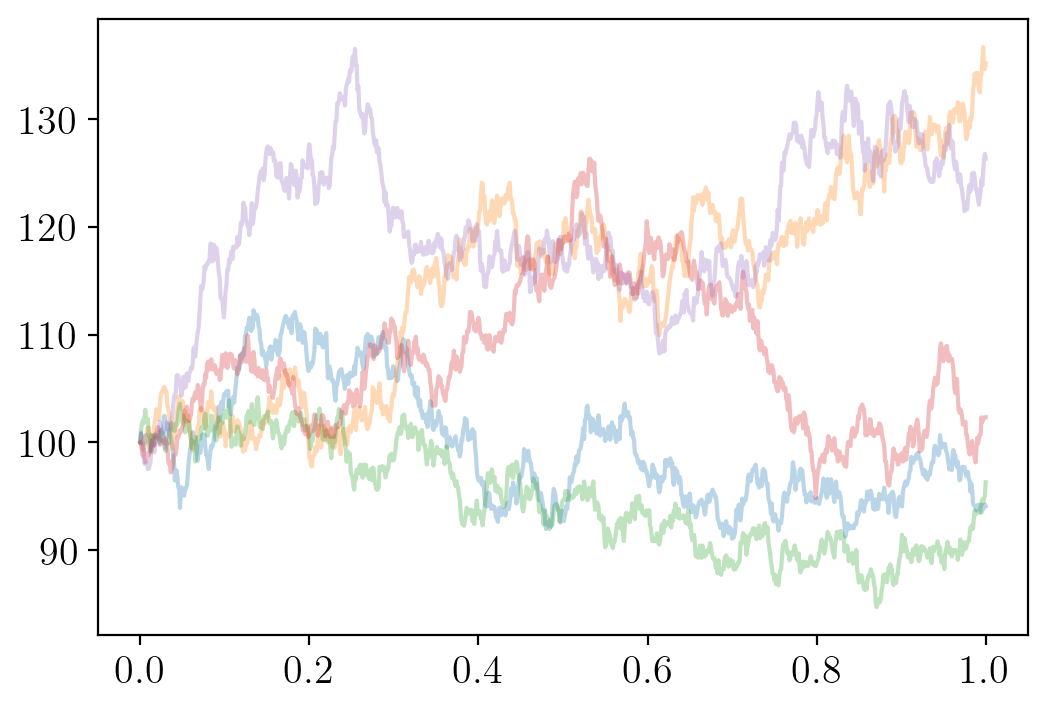

In [8]:
plt.plot(GBM.timesteps, GBM.simulate(nsims = 5), alpha = 0.3)
plt.show()

# Pricing with the binomial tree

In [9]:
default_params = {
'K' : 100,
't' : 0,
'T' : 1,
'r' : 0.03,
'S' : 100,
'sigma' : 0.1
}

K = default_params['K']
S = np.linspace(start = 50,stop = 150, num = 100)
t = default_params['t']
S0 = default_params['S']
T = default_params['T']
r = default_params['r']
mu = 0.1
sigma = default_params['sigma']

In [10]:
from src.utils import put_option_payoff
def put_option_payoff_fixed_K(x):
    return put_option_payoff(K, x)

Nt = 1_001
u = 1. + sigma * np.sqrt(T/Nt)
d = 1./u
p = 0.5 + (mu / (2.*sigma) - sigma/4)* np.sqrt(T/Nt)

params = {
    'r' : r,
    'p' : p,
    'u' : u,
    'd' : d,
    'T' : T,
    'S0' : S0,
    'Nt': Nt,
    'payoff_fct' : put_option_payoff_fixed_K,
    'american' : False
}

BT = utils.binomial_tree(**params)

## Sanity check

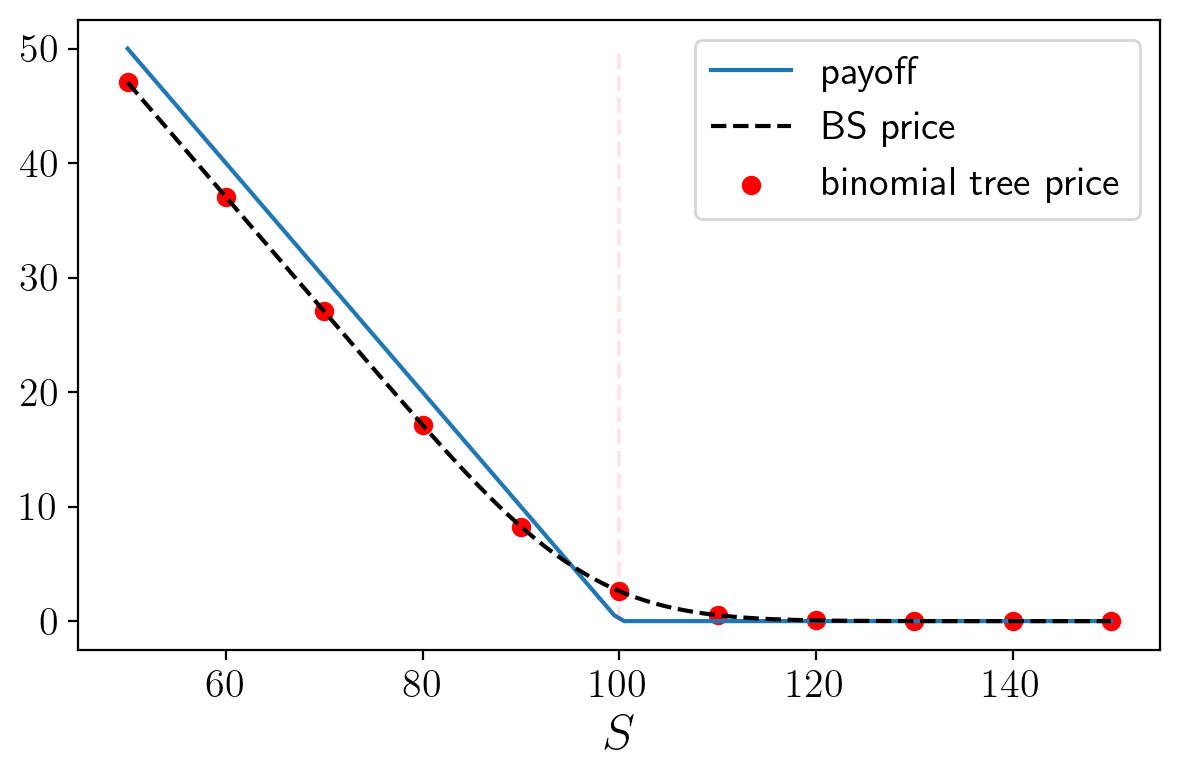

In [11]:
prices = utils.computeBlackScholesPutPrice(t,T,S,r,sigma,K)
payoff = utils.put_option_payoff(K = K, S = S)



plt.figure()
plt.plot(S, payoff, linestyle = '-', label='payoff')
plt.plot(S, prices, linestyle = '--', color='black', label='BS price')
plt.vlines(x = K, ymin = 0, ymax = np.max(payoff), color = 'r', linestyles='--', alpha = 0.1)

S_small = np.linspace(start = 50,stop = 150, num = 11)
price_BT = np.zeros_like(S_small)
for iS,s in enumerate(S_small):
    params_aux = params.copy()
    params_aux['S0'] = s
    BT = utils.binomial_tree(**params_aux)
    price_BT[iS] = BT.derivative_price_at_zero

plt.scatter(S_small, price_BT, marker = 'o', color='red', label= 'binomial tree price')
resolution_value = 50
plt.tight_layout()
plt.legend()
plt.xlabel(r'$S$',  fontsize=18)
plt.tight_layout()
plt.savefig('../figures/put-price-vs-payoff-vs-BT.pdf', format="pdf", dpi=resolution_value)
plt.show()

## Sanity check

In [12]:
def identity_fct(S):
    return S
params_aux = params.copy()
params_aux['payoff_fct'] = identity_fct

BT = utils.binomial_tree(**params_aux)
BT.derivative_price_at_zero

99.99999999999729

# American put option

In [13]:
params['american'] = False
BT = utils.binomial_tree(**params)
BT.derivative_price_at_zero

2.6213811690730693

In [14]:
params['american'] = True
BT = utils.binomial_tree(**params)
BT.derivative_price_at_zero

2.9206864319043895

In [15]:
AUX = np.multiply(BT.asset_prices,BT.exercise_early)

In [16]:
boundary = np.max(AUX, axis = 0)
idx = np.where(boundary==0)
boundary[idx] = np.NaN

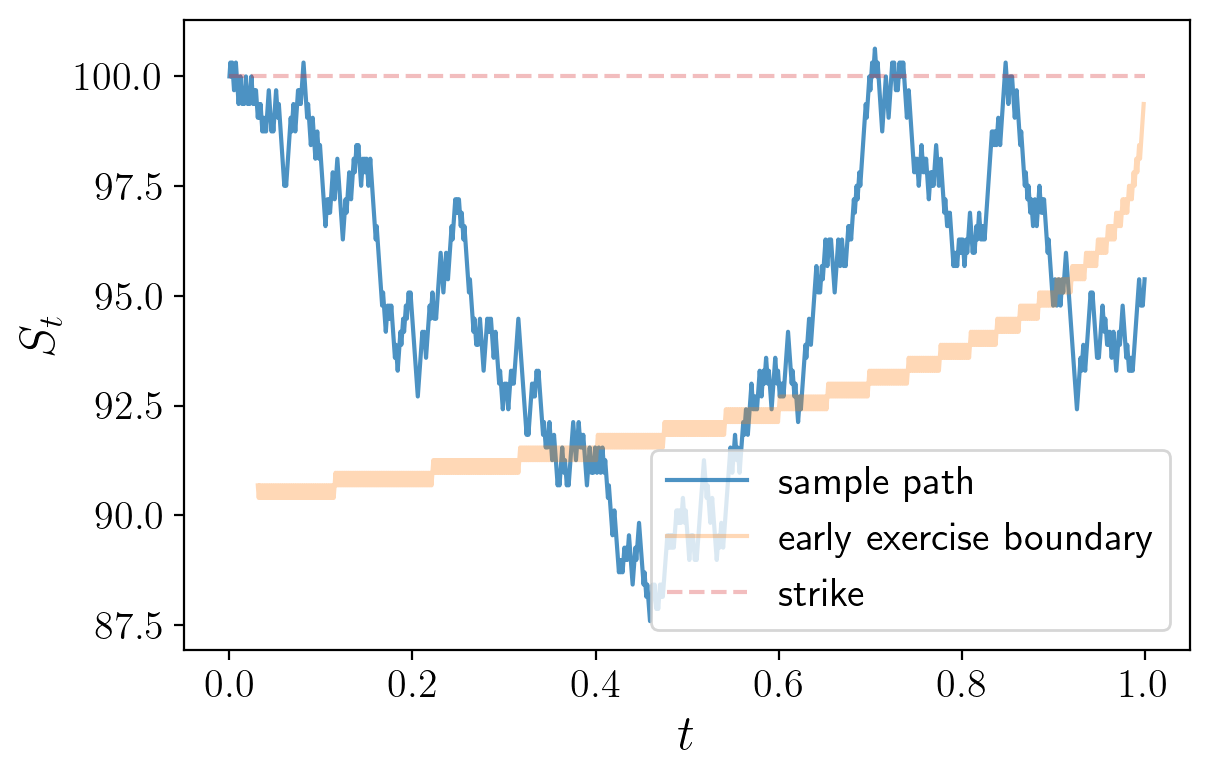

In [17]:
np.random.seed(1234)
plt.plot(BT.timesteps, BT.simulate(nsims = 1), alpha = 0.8, color='tab:blue', label='sample path')
plt.plot(BT.timesteps, boundary, alpha = 0.3, color='tab:orange', label = 'early exercise boundary')
plt.plot(BT.timesteps, np.ones_like(BT.timesteps)*K, linestyle='--', color='tab:red', alpha = 0.3, label = 'strike')

resolution_value = 50
plt.tight_layout()
plt.legend()
plt.xlabel(r'$t$',  fontsize=18)
plt.ylabel(r'$S_t$',  fontsize=18)
plt.tight_layout()
plt.savefig('../figures/sample-path-boundary-put-option-BT.pdf', format="pdf", dpi=resolution_value)
plt.show()